In [57]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# Evaluación de la Robustez
import yfinance as yf

In [58]:
df_original = yf.Ticker('NQ=F')
df_original = df_original.history(start='2010-01-01', end='2024-01-01')

### Función de backtest para la estrategia de medias móviles con cálculo de Sharpe y retorno total

In [ ]:
def backtest_strategy(data, sma_1, sma_2):
    # Copiar el DataFrame original
    df = data.copy()

    # Crear medias móviles simples (SMA)
    df['SMA_1'] = df['Close'].rolling(window=sma_1).mean()
    df['SMA_2'] = df['Close'].rolling(window=sma_2).mean()

    # Generar señales de compra/venta
    df['Signal'] = 0
    df.loc[df['SMA_1'] > df['SMA_2'], 'Signal'] = 1
    df.loc[df['SMA_1'] < df['SMA_2'], 'Signal'] = -1

    # Desplazar posición para evitar "mirar al futuro"
    df['Position'] = df['Signal'].shift()

    # Asegurarse de que 'Position' y 'Close.pct_change()' sean Series unidimensionales
    position = df['Position'].fillna(0).squeeze()  # Convertir a Series 1D
    pct_change = df['Close'].pct_change().fillna(0).squeeze()  # Convertir a Series 1D

    # Cálculo de retornos de la estrategia (producto escalar entre Series)
    df['Strategy_Returns'] = (position * pct_change).squeeze()

    # Eliminar filas con NaN generadas por el cálculo de medias móviles
    df.dropna(inplace=True)

    # Calcular el rendimiento total
    total_return = (df['Strategy_Returns'] + 1).prod() - 1

    # Calcular el ratio de Sharpe
    avg_return = df['Strategy_Returns'].mean()
    risk = df['Strategy_Returns'].std()
    sharpe_ratio = avg_return / risk if risk != 0 else np.nan

    return total_return, sharpe_ratio


In [60]:
# Parámetros base optimizados
base_sma_1 = 50
base_sma_2 = 200

In [61]:
# Definir diferentes periodos para pruebas de robustez
periods = [
    ('2010-01-01', '2013-01-01'),
    ('2013-01-01', '2016-01-01'),
    ('2016-01-01', '2019-01-01'),
    ('2019-01-01', '2024-01-01')
]

In [62]:
# Evaluar la estrategia en diferentes periodos
print("Evaluación de Robustez - Resultados en Diferentes Periodos de Tiempo")
for start, end in periods:
    df_period = yf.download('NQ=F', start=start, end=end)
    total_return, sharpe_ratio = backtest_strategy(df_period, base_sma_1, base_sma_2)
    print(f'Periodo {start} a {end} - Rendimiento Total: {total_return:.2%}, Sharpe Ratio: {sharpe_ratio:.2f}')

[*********************100%***********************]  1 of 1 completed

Evaluación de Robustez - Resultados en Diferentes Periodos de Tiempo
Periodo 2010-01-01 a 2013-01-01 - Rendimiento Total: 7.91%, Sharpe Ratio: 0.02


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Periodo 2013-01-01 a 2016-01-01 - Rendimiento Total: 16.25%, Sharpe Ratio: 0.03


Periodo 2016-01-01 a 2019-01-01 - Rendimiento Total: 49.83%, Sharpe Ratio: 0.07


[*********************100%***********************]  1 of 1 completed

Periodo 2019-01-01 a 2024-01-01 - Rendimiento Total: 148.21%, Sharpe Ratio: 0.06


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


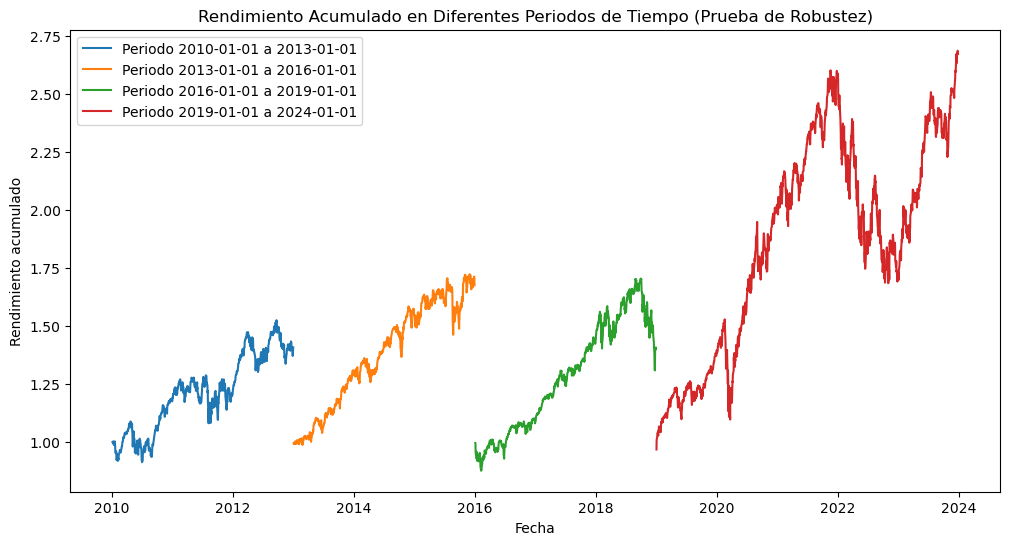

In [63]:
# Visualizar resultados para robustez en cada periodo (rendimiento acumulado)
plt.figure(figsize=(12, 6))

for start, end in periods:
    df_period = yf.download('NQ=F', start=start, end=end)
    df_period_result = backtest_strategy(df_period, base_sma_1, base_sma_2)
    cumulative_returns = np.cumprod(df_period['Close'].pct_change() + 1)
    plt.plot(cumulative_returns, label=f'Periodo {start} a {end}')

plt.title('Rendimiento Acumulado en Diferentes Periodos de Tiempo (Prueba de Robustez)')
plt.xlabel('Fecha')
plt.ylabel('Rendimiento acumulado')
plt.legend()
plt.show()